In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


mtalbert = pd.read_csv('../Data/soil data/AcrossAucklandRainfallStation/MtAlbert_Data_15mins.csv', index_col=['Timestamp (UTC+12:00)'], parse_dates=['Timestamp (UTC+12:00)'])
mtalbert.head()


,Rain(mm),SoilTemp(c),SoilMoisture(%)
Timestamp (UTC+12:00),,,
2018-07-07 11:15:00,0.0,10.4,37.364
2018-07-07 11:30:00,0.0,10.4,37.594
2018-07-07 11:45:00,0.0,10.4,37.590
2018-07-07 12:00:00,0.0,10.5,37.587
2018-07-07 12:15:00,0.0,10.5,37.584


In [19]:
mtalbert_soil = mtalbert.resample('H').agg({
    'Rain(mm)': 'sum',
    'SoilTemp(c)': 'mean',
    'SoilMoisture(%)': 'mean'
})

In [20]:
mtalbert_soil.index.freq

<Hour>

In [21]:
mtalbert_soil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55162 entries, 2018-07-07 11:00:00 to 2024-10-21 20:00:00
Freq: h
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Rain(mm)         55162 non-null  float64
 1   SoilTemp(c)      46897 non-null  float64
 2   SoilMoisture(%)  46897 non-null  float64
dtypes: float64(3)
memory usage: 1.7 MB


In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima


In [24]:
mtalbert_soil.isna().sum()


Rain(mm)              0
SoilTemp(c)        8265
SoilMoisture(%)    8265
dtype: int64

In [25]:
mtalbert_soil['SoilMoisture(%)'].interpolate(method='linear', inplace=True)


<Axes: xlabel='Timestamp (UTC+12:00)'>

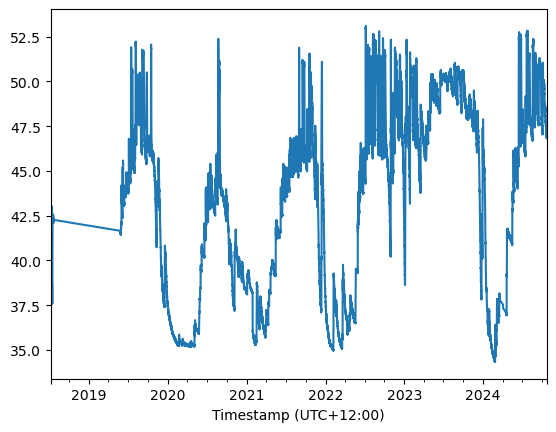

In [26]:
mtalbert_soil['SoilMoisture(%)'].plot()

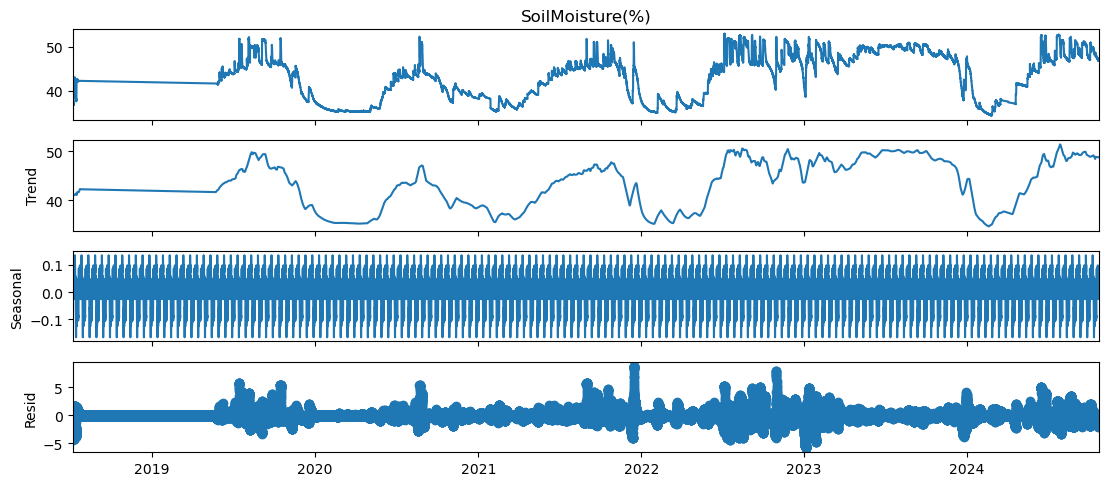

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
mtalbert_soil_seasonal_component = seasonal_decompose(mtalbert_soil['SoilMoisture(%)'], model='additive', period=365, extrapolate_trend='freq') 
fig = mtalbert_soil_seasonal_component.plot()
fig.set_size_inches((12, 5))
plt.show()

In [28]:
auto_arima(mtalbert_soil['SoilMoisture(%)'], seasonal=True, m=12)

MemoryError: Unable to allocate 284. MiB for an array with shape (26, 26, 55162) and data type float64

In [ ]:
features = len(mtalbert_soil) * 0.8

In [ ]:
train = mtalbert_soil.iloc[:features]
test = mtalbert_soil.iloc[features:]

In [ ]:
model = SARIMAX(train['SoilMoisture(%)'], order=(0,1,1), seasonal_order=(1,0,1,12))

In [ ]:
results = model.fit()
results.summary()

In [ ]:
start = len(train)
end = len(train) + len(test) - 1

In [ ]:
predictions= results.predict(start, end, type='levels').rename('SARIMA Predictions')

In [ ]:
test['SoilMoisture(%)'].plot(legent=True, figsize=(12,8))
predictions.plot(legend=True)

In [ ]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['SoilMoisture(%)'], predictions)
error

# Forecast

In [ ]:
model = SARIMAX(train['SoilMoisture(%)'], order=(0,1,1), seasonal_order=(1,0,1,12))
results = model.fit()


In [ ]:
forecast = results.predict(len(mtalbert_soil), len(mtalbert_soil)+672, type='level').rename('SARIMA FORECAST')

In [ ]:
mtalbert_soil['SoilMoisture(%)'].plot(lengend=True, figsize=(12,8))
forecast.plot(leneng=True)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, mse, rmse, r2

rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(forecast, test)

print("\nXGBoost Testing Set Metrics:")
print(f"MAE: {rf_mae}")
print(f"MSE: {rf_mse}")
print(f"RMSE: {rf_rmse}")
print(f"R2 Score: {rf_r2}")